In [30]:
import json 
import glob
import os
import pymysql
import numpy as np
# the file to be converted to  
# json format 
def create_data_list():
    path = 'D:/Data Science/Principles of Data Management/project/data/Disqus file'
    fileList = []
    for filename in os.listdir(path):
            #content = open(os.path.join(path, filename), 'r')
            fileList.append(filename)

    dictList = []
    print("Started Reading JSON file which contains multiple JSON document")
    for file in fileList:
        with open(path + "/" + file) as f:
            for jsonObj in f:
                d = json.loads(jsonObj)
                dictList.append(d)
    print(len(dictList))
    return dictList

In [2]:
class ID:
    def __init__(self):
        self.permalink_id = 1
        self.avatar_id = 1
        self.maintable_id = 1
    def incr_permalink(self):
        self.permalink_id = self.permalink_id + 1
    def incr_avatar(self):
        self.avatar_id = self.avatar_id + 1
    def incr_maintable(self):
        self.maintable_id = self.maintable_id + 1

In [3]:


def create_tables(cursor):
    cursor.execute("CREATE TABLE permalink (ID INT AUTO_INCREMENT PRIMARY KEY, permalink VARCHAR(255), cache VARCHAR(255))")

    cursor.execute("CREATE TABLE avatar (ID INT AUTO_INCREMENT PRIMARY KEY, smallpermalinkID INT, \
                                        isCustom BIT, permalinkID INT, largePermalinkID INT)")

    cursor.execute("CREATE TABLE author (username VARCHAR(255), about LONGTEXT, name VARCHAR(255), \
                  disable3rdPartyTrackers BIT, isPowerContributor BIT, joinedAt DATETIME, profileUrl VARCHAR(255), \
                  url VARCHAR(255), location VARCHAR(255), isPrivate BIT, signedUrl VARCHAR(255), \
                  isPrimary BIT, isAnonymous BIT, id VARCHAR(255) PRIMARY KEY, avatarID INT, \
                  FOREIGN KEY(avatarID) REFERENCES avatar(ID))")

    cursor.execute("CREATE TABLE mainTable (tID INT AUTO_INCREMENT PRIMARY KEY, prev VARCHAR(255), hasNext BIT, \
                   next VARCHAR(255), hasPrev BIT, total VARCHAR(255), id VARCHAR(255), more BIT, code INT)")

    cursor.execute("CREATE TABLE response (editableUntil DATETIME, dislikes INT, numReports INT, likes INT, \
    message LONGTEXT, id VARCHAR(255) PRIMARY KEY, createdAt DATETIME, authorID VARCHAR(255), media VARCHAR(255), isSpam BIT,\
    isDeletedByAuthor BIT, isDeleted BIT, parent VARCHAR(255), isApproved BIT, isFlagged BIT, raw_message LONGTEXT, \
    isHighlighted BIT, canVote BIT, thread VARCHAR(255), forum VARCHAR(255), \
    points INT, moderationLabels VARCHAR(255), isEdited BIT, sb BIT, FOREIGN KEY(authorID) REFERENCES author(id))")

    cursor.execute("CREATE TABLE connector (main_ID INT, response_ID VARCHAR(255), \
    FOREIGN KEY(main_ID) REFERENCES maintable(tID), FOREIGN KEY(response_ID) REFERENCES response(id))")


In [4]:
def insert_into_maintable(val, cursor):
    
    sql = "INSERT INTO maintable (prev, hasNext, next, hasPrev , total , id , more, code) \
                                VALUES (%s, %s, %s, %s, %s, %s, %s, %s)"
    cursor.execute(sql, val)

In [5]:
def insert_maintable(cursorList, code, cursor):
    l = []
    for i in cursorList:
        if cursorList[i] == False:
            l.append(0)
        elif cursorList[i] == True:
            l.append(1)
        elif cursorList[i] == None:
            l.append(None)
        else:
            l.append(cursorList[i])
    l.append(code)
    ans = tuple(l)
    insert_into_maintable(ans, cursor)

In [6]:
def insert_permalink(permalink, cache, cursor):
    val = (permalink, cache)
    
    sql = "INSERT INTO permalink (permalink, cache) \
                                VALUES (%s, %s)"
    cursor.execute(sql, val)

In [7]:
def insert_avatar(val, cursor):

    sql = "INSERT INTO avatar (smallpermalinkID, isCustom, permalinkID, largePermalinkID ) \
                                VALUES (%s, %s, %s, %s)"
    cursor.execute(sql, val)

In [8]:
def parse_avatar(avatar, saveID, cursor):
    l = []
    
    insert_permalink(avatar['small']['permalink'], avatar['small']['cache'], cursor)
    l.append(saveID.permalink_id)
    saveID.incr_permalink()
    if avatar.get('isCustom') is None or avatar['isCustom'] == False:
        l.append(0)
    else:
        l.append(1)
        
    insert_permalink(avatar['permalink'], avatar['cache'], cursor)
    l.append(saveID.permalink_id)
    saveID.incr_permalink()
    
    insert_permalink(avatar['large']['permalink'], avatar['large']['cache'], cursor)
    l.append(saveID.permalink_id)
    saveID.incr_permalink()
    
    t = tuple(l)
    insert_avatar(t, cursor)
            
            

In [9]:
def insert_author(val, author_id, cursor):

    sql = "SELECT * FROM author WHERE id = %s"
    adr = (author_id, )
    cursor.execute(sql, adr)
    data = cursor.fetchall()
    if not data:
        sql = "INSERT INTO author (username, about, name, disable3rdPartyTrackers, isPowerContributor, joinedAt, profileUrl, \
                                url, location, isPrivate, signedUrl, isPrimary, isAnonymous, id, avatarID) \
                                VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s)"
        cursor.execute(sql, val)


In [10]:
def parse_author(author, saveID, cursor):
    l = []
    for a in author:
        if a == 'avatar':
            parse_avatar(author[a], saveID, cursor)
        elif a == 'joinedAt':
            k = author[a].split("T")
            ans = k[0] + " " +k[1]
            l.append(ans)
        elif author[a] == True:
            l.append(1)
        elif author[a] == False:
            l.append(0)
        elif author[a] == "":
            l.append(None)
        else:
            l.append(author[a])
    l.append(saveID.avatar_id)
    saveID.incr_avatar()
    val = tuple(l)
    if author.get('id') is None:
        return None
    insert_author(val, author['id'], cursor)
    return author['id']

In [11]:
def insert_into_response(val, response_id, cursor):
  
    sql = "SELECT * FROM response WHERE id = %s"
    adr = (response_id, )
    cursor.execute(sql, adr)
    data = cursor.fetchall()
    if not data:
        sql = "INSERT INTO response (editableUntil, dislikes, numReports, likes, message, id, createdAt, authorID, media,\
        isSpam, isDeletedByAuthor, isDeleted, parent, isApproved, isFlagged, raw_message, isHighlighted,\
        canVote, thread, forum, points, moderationLabels, isEdited, sb)\
                                    VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, \
                                            %s, %s, %s, %s, %s, %s, %s, %s, %s)"
        cursor.execute(sql, val)

In [12]:
def parse_response(elem, saveID, cursor):
    l = []
    for e in elem:
        a = elem[e]
        if e == 'media' or e == 'moderationLabels':
            if(len(a) == 0):
                l.append(None)
            else:
                l.append(a[0])
        elif e == 'editableUntil' or e == 'createdAt':
            k = a.split("T")
            ans = k[0] + " " +k[1]
            l.append(ans)
        elif e == 'author':
            authorID = parse_author(a, saveID, cursor)
            l.append(authorID)
        elif a == True:
            l.append(1)
        elif a == False:
            l.append(0)
        else:
            l.append(a)
    val = tuple(l)
    insert_into_response(val, elem['id'], cursor)
    return elem['id']

In [13]:
def insert_response(resp, saveID, cursor):
    respid = []
    for elem in resp:
        re = parse_response(elem, saveID, cursor)
        respid.append(re)
    return respid

In [14]:
def insert_into_connector(val, cursor):

    sql = "SELECT * FROM connector WHERE main_ID = %s and response_ID = %s"
    adr = (val[0], val[1],)
    cursor.execute(sql, adr)
    data = cursor.fetchall()
    if not data:
        sql = "INSERT INTO connector (main_ID, response_ID) \
                                VALUES (%s, %s)"
        cursor.execute(sql, val)

In [15]:
def insert_connector(maintable_id, respid, cursor):
    for i in respid:
        val = (maintable_id, i)
        insert_into_connector(val, cursor)

In [16]:
def parse_json(element, saveID, cursor):
    insert_maintable(element['cursor'], element['code'], cursor)
    respid = insert_response(element['response'], saveID, cursor)
    insert_connector(saveID.maintable_id, respid, cursor)
    saveID.incr_maintable()

In [17]:
def insert_parse_value(dictList, saveID, cursor):
    if dictList != None:
        for element in dictList:
            parse_json(element, saveID, cursor)

In [18]:
def main():
    db_name = 'project'
    con = pymysql.connect(host = 'localhost',user = 'root',passwd = 'Data2020ScienceTU!@#',db = db_name)
    cursor = con.cursor()
    
    
    saveID = ID()
    dictList = create_data_list()
    create_tables(cursor)
    insert_parse_value(dictList, saveID, cursor)
    
    con.commit()
    con.close()
main()

Started Reading JSON file which contains multiple JSON document
24


In [18]:
def large_data():
    # the file to be converted to  
    # json format 
    
    path = 'D:/Data Science/Principles of Data Management/project/data/For Merge Disqus'
    fileList = []
    for filename in os.listdir(path):
            #content = open(os.path.join(path, filename), 'r')
            fileList.append(filename)

    dictList = []
    print("Started Reading JSON file which contains multiple JSON document")
    for file in fileList:
        with open(path + "/" + file) as f:
            for jsonObj in f:
                d = json.loads(jsonObj)
                dictList.append(d)
    print(len(dictList))
    return dictList

In [19]:
def main2():
    db_name = 'bigproject'
    con = pymysql.connect(host = 'localhost',user = 'root',passwd = 'Data2020ScienceTU!@#',db = db_name)
    cursor = con.cursor()
    
    saveID = ID()
    dictList = large_data()
    create_tables(cursor)
    insert_parse_value(dictList, saveID, cursor)
    
    con.commit()
    con.close()
main2()

Started Reading JSON file which contains multiple JSON document
2891


In [20]:
import pymysql
def queries(cursor):
    
    #1
    q1 = "select * from author where location is null;"
    cursor.execute(q1)
    #2
    q2 = "select a.username, a.location, a.id from author a join author b \
            where a.location is not null and b.location is not null \
                    and a.id != b.id and a.location = b.location order by a.location;"
    cursor.execute(q2)
    #3
    q3 = "select a.username, a.id, r.message from author a join response r on authorID = a.id \
                where message like '%Maybe%' and message like '%Trump%' and message like '%car%';"
    cursor.execute(q3)
    #4
    q4 = "select a.location, a.id, b.id from author a join author b \
                    on a.location is not null and b.location is not null and a.id > b.id and a.location = b.location \
                    join response ar on ar.authorID = a.id and ar.message like '%he%' \
                    join response br on br.authorID = b.id and br.message like '%he%' \
                    group by a.location, a.id, b.id;"
    cursor.execute(q4)
    #5
    q5 = "select id, count(message) from (select message, username, author.id from response join author \
                    where response.authorID = author.id) posts \
                    group by id ORDER BY count(message) desc limit 10;"
    cursor.execute(q5)
     
    #6
    q6 = "select * from author a where not exists (select r.id from response r where parent is null and authorID = a.id);"
    cursor.execute(q6)

    #7
    q7 = "select * from author a where not exists (select r.id from response r where parent is not null and authorID = a.id);"
    cursor.execute(q7)
    
    #8
    q8 = "select authorID, avg(likes), avg(dislikes) from response \
            where authorID is not null group by authorID order by avg(likes);"
    cursor.execute(q8)


In [21]:
import time
def get_time(cursor):
    start_time = time.time()
    queries(cursor)
    return (time.time() - start_time)

In [22]:
l = []
db_name = 'bigproject'
con = pymysql.connect(host = 'localhost',user = 'root',passwd = 'Data2020ScienceTU!@#',db = db_name)
cursor = con.cursor()

ans = get_time(cursor)
print(ans)
l.append(ans)

con.commit()
con.close()

8.235968351364136


In [52]:
def query1(cursor):
    
    #1
    q1 = "select id, username from author where location is null;"
    cursor.execute(q1)
    
def query2(cursor):    
    #2
    q2 = "select a.username, a.location, a.id from author a join author b \
            where a.location is not null and b.location is not null \
                    and a.id != b.id and a.location = b.location order by a.location;"
    cursor.execute(q2)
def query3(cursor):     
    #3
    q3 = "select a.username, a.id, r.message from author a join response r on authorID = a.id \
                where message like '%Maybe%' and message like '%Trump%' and message like '%car%';"
    cursor.execute(q3)
    
def query4(cursor):    
    #4
    q4 = "select a.location, a.id, b.id from author a join author b \
                    on a.location is not null and b.location is not null and a.id > b.id and a.location = b.location \
                    join response ar on ar.authorID = a.id and ar.message like '%he%' \
                    join response br on br.authorID = b.id and br.message like '%he%' \
                    group by a.location, a.id, b.id;"
    cursor.execute(q4)
def query5(cursor):    
    #5
    q5 = "select id, count(message) from (select message, username, author.id from response join author \
                    where response.authorID = author.id) posts \
                    group by id ORDER BY count(message) desc limit 10;"
    cursor.execute(q5)

def query6(cursor):    
    #6
    q6 = "select * from author a where not exists (select r.id from response r where parent is null and authorID = a.id);"
    cursor.execute(q6)

def query7(cursor):
    #7
    q7 = "select * from author a where not exists (select r.id from response r where parent is not null and authorID = a.id );"
    cursor.execute(q7)

def query8(cursor):
    #8
    q8 = "select authorID, avg(likes), avg(dislikes) from response \
            where authorID is not null group by authorID order by avg(likes);"
    cursor.execute(q8)


In [53]:
def count_time(cursor, func):
    start_time = time.time()
    func(cursor)
    return (time.time() - start_time)

In [54]:
l = []
db_name = 'bigproject'
con = pymysql.connect(host = 'localhost',user = 'root',passwd = 'Data2020ScienceTU!@#',db = db_name)
cursor = con.cursor()

ans1 = count_time(cursor, query1)
l.append(ans1)
ans2 = count_time(cursor, query2)
l.append(ans2)
ans3 = count_time(cursor, query3)
l.append(ans3)
ans4 = count_time(cursor, query4)
l.append(ans4)
ans5 = count_time(cursor, query5)
l.append(ans5)
ans6 = count_time(cursor, query6)
l.append(ans6)
ans7 = count_time(cursor, query7)
l.append(ans7)
ans8 = count_time(cursor, query8)
l.append(ans8)

print(ans1)
print(ans2)
print(ans3)
print(ans4)
print(ans5)
print(ans6)
print(ans7)
print(ans8)
print(ans1 + ans2 + ans3 + ans4 + ans5 + ans6 + ans7 + ans8)
con.commit()
con.close()

0.08274412155151367
0.05585145950317383
0.4697754383087158
0.6153583526611328
0.5903844833374023
0.4388244152069092
0.4847424030303955
5.322722911834717
8.06040358543396


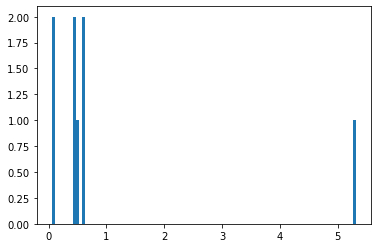

In [55]:
import matplotlib.pyplot as plt

plt.hist(l, bins = 100)
plt.show()

In [62]:
l1 = []
l2 = []
l3 = []
l4 = []
l5 = []
l6 = []
l7 = []
l8 = []
db_name = 'bigproject'
con = pymysql.connect(host = 'localhost',user = 'root',passwd = 'Data2020ScienceTU!@#',db = db_name)
cursor = con.cursor()
for i in range(5):
    ans1 = count_time(cursor, query1)
    l1.append(ans1)
    ans2 = count_time(cursor, query2)
    l2.append(ans2)
    ans3 = count_time(cursor, query3)
    l3.append(ans3)
    ans4 = count_time(cursor, query4)
    l4.append(ans4)
    ans5 = count_time(cursor, query5)
    l5.append(ans5)
    ans6 = count_time(cursor, query6)
    l6.append(ans6)
    ans7 = count_time(cursor, query7)
    l7.append(ans7)
    ans8 = count_time(cursor, query8)
    l8.append(ans8)
con.commit()
con.close()

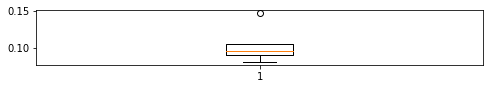

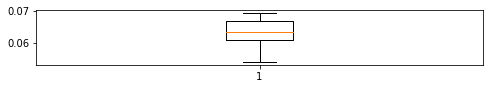

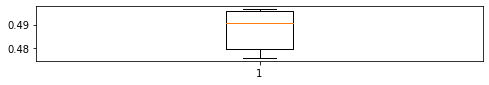

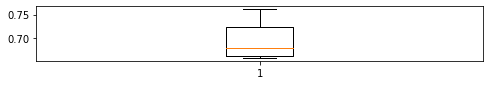

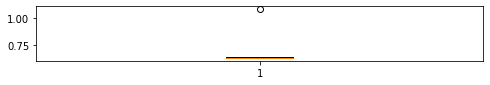

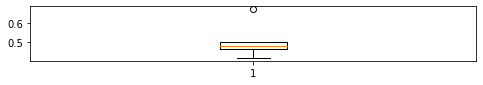

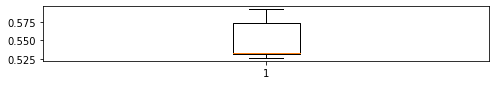

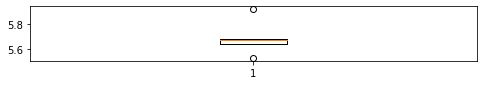

In [57]:
import matplotlib.pyplot as plt 
# Create a figure instance
fig = plt.figure(1, figsize=(8, 1))
# Create an axes instance
ax = fig.add_subplot(111)
# Create the boxplot
bp = ax.boxplot(l1)

fig = plt.figure(2, figsize=(8, 1))
# Create an axes instance
ax = fig.add_subplot(111)
# Create the boxplot
bp = ax.boxplot(l2)

fig = plt.figure(3, figsize=(8, 1))
# Create an axes instance
ax = fig.add_subplot(111)
# Create the boxplot
bp = ax.boxplot(l3)

fig = plt.figure(4, figsize=(8, 1))
# Create an axes instance
ax = fig.add_subplot(111)
# Create the boxplot
bp = ax.boxplot(l4)

fig = plt.figure(5, figsize=(8, 1))
# Create an axes instance
ax = fig.add_subplot(111)
# Create the boxplot
bp = ax.boxplot(l5)

fig = plt.figure(6, figsize=(8, 1))
# Create an axes instance
ax = fig.add_subplot(111)
# Create the boxplot
bp = ax.boxplot(l6)

fig = plt.figure(7, figsize=(8, 1))
# Create an axes instance
ax = fig.add_subplot(111)
# Create the boxplot
bp = ax.boxplot(l7)

fig = plt.figure(8, figsize=(8, 1))
# Create an axes instance
ax = fig.add_subplot(111)
# Create the boxplot
bp = ax.boxplot(l8)

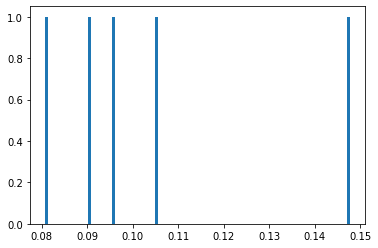

In [60]:
plt.hist(l1, bins = 100)
plt.show()

In [58]:
print(sum(l1) / len(l1))
print(sum(l2) / len(l2))
print(sum(l3) / len(l3))
print(sum(l4) / len(l4))
print(sum(l5) / len(l5))
print(sum(l6) / len(l6))
print(sum(l7) / len(l7))
print(sum(l8) / len(l8))

0.10401558876037598
0.06284289360046387
0.4877377986907959
0.6964607238769531
0.7218634605407714
0.5086816310882568
0.551052188873291
5.687981271743775


In [70]:

db_name = 'bigproject'
con = pymysql.connect(host = 'localhost',user = 'root',passwd = 'Data2020ScienceTU!@#',db = db_name)
cursor = con.cursor()
ll = []
for i in range(5):
    ans1 = min(ans1, count_time(cursor, query1))
print(ans1)
ll.append(ans1)
for i in range(10):
    ans2 = min(ans2, count_time(cursor, query2))
print(ans2)
ll.append(ans2)
for i in range(10):
    ans3 = min(ans3, count_time(cursor, query3))
print(ans3)
ll.append(ans3)
for i in range(10):
    ans4 = min(ans4, count_time(cursor, query4))
print(ans4)
ll.append(ans4)
for i in range(10):
    ans5 = min(ans5, count_time(cursor, query5))
print(ans5)
ll.append(ans5)
for i in range(10):
    ans6 = min(ans6, count_time(cursor, query6))
print(ans6)
ll.append(ans6)
for i in range(10):
    ans7 = min(ans7, count_time(cursor, query7))
print(ans7)
ll.append(ans7)
for i in range(10):
    ans8 = min(ans8, count_time(cursor, query8))
ll.append(ans8)
print(ans8)
ans = ans1 + ans2 + ans3 + ans4 + ans5 + ans6 + ans7 + ans8
print(ans)
con.commit()
con.close()

0.0747995376586914
0.05485343933105469
0.42885255813598633
0.5844361782073975
0.5245876312255859
0.41887950897216797
0.46878480911254883
5.171165943145752
7.726359605789185


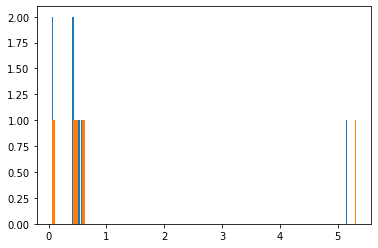

In [71]:
plt.hist(ll, bins = 200)
plt.hist(l, bins = 200)
plt.show()